# Test data process (xyz + uv + normal)

In [ ]:
import os
import sys

sys.path.insert(0, os.path.abspath('..'))

from data_process.geometry_utils.obj import read_obj

mesh_fp = '../resources/examples/0000/0000.obj'
mesh_obj = read_obj(mesh_fp)

print('*** verts: ', mesh_obj.points.shape, mesh_obj.points.max(axis=0), mesh_obj.points.min(axis=0))
print('*** uvs: ', mesh_obj.point_data['obj:vt'].shape, mesh_obj.point_data['obj:vt'].max(axis=0), mesh_obj.point_data['obj:vt'].min(axis=0))
print('*** normals: ', mesh_obj.point_data['obj:vn'].shape, mesh_obj.point_data['obj:vn'].max(axis=0), mesh_obj.point_data['obj:vn'].min(axis=0))


## Visualize Geometry && Edges

In [ ]:
import os
import random
import pickle
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches 
from matplotlib.colors import to_rgb


from glob import glob

_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias": "橡筋", "color": "#696969"},
    "木耳边": {"alias": "木耳边", "color": "#696969"},
    "袖笼拼条": {"alias": "袖笼拼条", "color": "#696969"},
    "荷叶边": {"alias": "荷叶边", "color": "#696969"
            
            },
    "绑带": {"alias": "绑带", "color": "#696969"}
}

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']


def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    
    print('[_to_o3d_pc] color: ', pcd.points)
        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)

    return pcd

def _draw_bboxes_2d(ax, bboxes_min, bboxes_max, color='r'):
    
    num_points = bboxes_min.shape[0]
    print(bboxes_min.shape, bboxes_max.shape, num_points)
    
    for idx in range(num_points):
        p0_ = bboxes_min[idx]
        p1_ = bboxes_max[idx]
        
        # Extract coordinates
        x0, y0 = p0_
        x1, y1 = p1_
        
        # Calculate width and height of the bounding box
        
        width = x1 - x0
        height = y1 - y0
        
        # Create a rectangle patch
        rect = patches.Rectangle(
            (x0, y0), width, height, linestyle='--', linewidth=1, 
            edgecolor=color, 
            facecolor='none')
        
        # Add the rectangle to the plot
        ax.add_patch(rect)
        
    
data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_reso_256\\"
data_path = random.choice(glob(os.path.join(data_root, '*.pkl')))
# data_path = os.path.join(data_root, '7529.pkl')

with open(data_path, "rb") as tf: data = pickle.load(tf)

print([x for x in data['faceEdge_adj'].items()])

print(data['data_fp'], data['surf_cls'])
print(data['surf_wcs'].shape, data['global_offset'], data['global_scale'])
print(data['edge_wcs'].shape, data['edge_uv_wcs'].shape)
print('*** ncs: ', data['surf_ncs'].shape, data['surf_ncs'].min(), data['surf_ncs'].max())

print('*** edge_bbox', data['edge_bbox_wcs'].shape, data['edge_uv_bbox_wcs'].shape, data['edge_ncs'].shape, data['edge_uv_ncs'].shape)

global_offset = np.array(data['global_offset'])[None]
global_scale = data['global_scale']

uv_offset = data['uv_offset'][None]
uv_scale = data['uv_scale']

########## CHECK WCS ###########
# surf_pnts = data['surf_mask'].reshape(-1, 1) * (data['surf_wcs'].reshape(-1, 3) * (global_scale * 0.5) + global_offset)
# edge_pnts = data['edge_wcs'].reshape(-1, 3) * (global_scale * 0.5) + global_offset
# surf_uvs = data['surf_mask'].reshape(-1, 1) * (data['surf_uv_wcs'].reshape(-1, 2) * (uv_scale * 0.5) + uv_offset)
# edge_uvs = data['edge_uv_wcs'].reshape(-1, 2) * (uv_scale * 0.5) + uv_offset
################################

########## CHECK NCS ###########
# Surface
bbox_scale = np.max(data['surf_bbox_wcs'][:, 3:] - data['surf_bbox_wcs'][:,:3], axis=1)[:, None, None, None]
bbox_offset = ((data['surf_bbox_wcs'][:, 3:] + data['surf_bbox_wcs'][:, :3]) * 0.5)[:, None, None, :]
surf_pnts_wcs = data['surf_mask'] * (data['surf_ncs'] * (bbox_scale * 0.5) + bbox_offset)
surf_pnts = data['surf_mask'].reshape(-1, 1) * (surf_pnts_wcs.reshape(-1, 3) * (global_scale * 0.5) + global_offset)

bbox_scale_uv = np.max(data['surf_uv_bbox_wcs'][:, 2:] - data['surf_uv_bbox_wcs'][:,:2], axis=1)[:, None, None, None]
bbox_offset_uv = ((data['surf_uv_bbox_wcs'][:, 2:] + data['surf_uv_bbox_wcs'][:, :2]) * 0.5)[:, None, None, :]
surf_uvs_wcs = data['surf_mask'] * (data['surf_uv_ncs'] * (bbox_scale_uv * 0.5) + bbox_offset_uv)
surf_uvs = data['surf_mask'].reshape(-1, 1) * (surf_uvs_wcs.reshape(-1, 2) * (uv_scale * 0.5) + uv_offset)
surf_masks = data['surf_mask'].reshape(-1).astype(bool)

# Edge
bbox_scale = np.max(data['edge_bbox_wcs'][:, 3:] - data['edge_bbox_wcs'][:,:3], axis=1)[:, None, None]
bbox_offset = ((data['edge_bbox_wcs'][:, 3:] + data['edge_bbox_wcs'][:, :3]) * 0.5)[:, None, :]
edge_pnts_wcs = data['edge_ncs'] * (bbox_scale * 0.5) + bbox_offset
edge_pnts = edge_pnts_wcs.reshape(-1, 3) * (global_scale * 0.5) + global_offset

bbox_scale_uv = np.max(data['edge_uv_bbox_wcs'][:, 2:] - data['edge_uv_bbox_wcs'][:,:2], axis=1)[:, None, None]
bbox_offset_uv = ((data['edge_uv_bbox_wcs'][:, 2:] + data['edge_uv_bbox_wcs'][:, :2]) * 0.5)[:, None, :]
edge_uvs_wcs = data['edge_uv_ncs'] * (bbox_scale_uv * 0.5) + bbox_offset_uv
edge_uvs = edge_uvs_wcs.reshape(-1, 2) * (uv_scale * 0.5) + uv_offset
################################

print('*** surf_pnts: ', surf_pnts.max(axis=0), surf_pnts.min(axis=0))
print('*** edge_pnts: ', edge_pnts.max(axis=0), edge_pnts.min(axis=0))
print('*** uv_offset: ', uv_offset.shape, uv_offset.max(axis=0), uv_offset.min(axis=0))


surf_colors = ((data['surf_normals'].reshape(-1, 3) + 1.0) * 0.5).clip(0, 1)
edge_colors = np.expand_dims(np.random.rand(data['edge_uv_wcs'].shape[0], 3), axis=1).repeat(data['edge_uv_wcs'].shape[1], axis=1).reshape(-1, 3)

surf_pcd = _to_o3d_pc(surf_pnts[surf_masks, :], surf_colors[surf_masks, :])
edge_pcd = _to_o3d_pc(edge_pnts, edge_colors)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.scatter(surf_uvs[surf_masks, 0], surf_uvs[surf_masks, 1], c=surf_colors[surf_masks, :], s=3.5)
ax.scatter(edge_uvs[:, 0], edge_uvs[:, 1], c=edge_colors, s=5)
ax.scatter(edge_uvs[:, 0], edge_uvs[:, 1], c=edge_colors, s=5)

surf_uv_bbox_min = data['surf_uv_bbox_wcs'][:, :2] * (uv_scale * 0.5) + uv_offset
surf_uv_bbox_max = data['surf_uv_bbox_wcs'][:, 2:] * (uv_scale * 0.5) + uv_offset
surf_color = np.random.rand(len(surf_uv_bbox_min), 3)
print('*** surf_color: ', surf_uv_bbox_max.shape, surf_color.shape)
_draw_bboxes_2d(ax, surf_uv_bbox_min, surf_uv_bbox_max, color=np.random.rand(3))

print('*** edge uv bbox: ', data['edge_uv_bbox_wcs'].shape)
edge_uv_bbox_min = data['edge_uv_bbox_wcs'][:, :2] * (uv_scale * 0.5) + uv_offset
edge_uv_bbox_max = data['edge_uv_bbox_wcs'][:, 2:] * (uv_scale * 0.5) + uv_offset
# _draw_bboxes_2d(ax, edge_uv_bbox_min, edge_uv_bbox_max, color=surf_color)

# plt.axis('off')
plt.axis('equal')
plt.show()

surf_bboxes_3d = []
surf_bbox_min = data['surf_bbox_wcs'][:, :3] * (global_scale * 0.5) + global_offset
surf_bbox_max = data['surf_bbox_wcs'][:, 3:] * (global_scale * 0.5) + global_offset
for idx in range(surf_bbox_min.shape[0]):
    surf_bboxes_3d.append(o3d.geometry.AxisAlignedBoundingBox(surf_bbox_min[idx][..., None], surf_bbox_max[idx][..., None]))
    surf_bboxes_3d[-1].color = to_rgb(_CMAP[_PANEL_CLS[data['surf_cls'][idx]-1]]['color'])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0., 0., 0.])
o3d.visualization.draw_geometries([surf_pcd, edge_pcd, mesh_frame] + surf_bboxes_3d)

## Visualize Surface Points (check mask)

In [ ]:
import os
import numpy as np
import pickle
import random
from glob import glob
from matplotlib import pyplot as plt
import math

plt.rcParams['font.sans-serif']=['SimHei'] # Show Chinese label
plt.rcParams['axes.unicode_minus']=False   # These two lines need to be set manually

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']
    
data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\"
data_path = random.choice(glob(os.path.join(data_root, '*.pkl')))

with open(data_path, "rb") as tf: data = pickle.load(tf)

print(data['data_fp'])

num_panels = data['surf_wcs'].shape[0]

n_cols = 8
n_rows = math.ceil(num_panels / n_cols)
print(num_panels, n_cols, n_rows)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20/n_cols*n_rows))

for idx in range(num_panels):   
    # img_arr = data['surf_wcs'][idx]
    img_arr = data['surf_mask'][idx] * (data['surf_wcs'][idx] + 1.0) * 0.5
    x_idx = idx // n_cols
    y_idx = idx % n_cols     
    axs[x_idx, y_idx].set_title(_PANEL_CLS[data['surf_cls'][idx]-1])
    axs[x_idx, y_idx].imshow(np.clip(img_arr[::-1, :, :], 0., 1.).astype(np.float32))

plt.show()

## Visualize 2D Bounding Boxes

In [ ]:
import os
import random
import pickle
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches 
from matplotlib.colors import to_rgb

from glob import glob

_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias": "橡筋", "color": "#DACBBD"},
    "木耳边": {"alias": "木耳边", "color": "#A8D4D2"},
    "袖笼拼条": {"alias": "袖笼拼条", "color": "#DACBBD"},
    "荷叶边": {"alias": "荷叶边", "color": "#A8D4D2"},
    "绑带": {"alias": "绑带", "color": "#696969"}
}

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']

def _draw_bboxes_2d(ax, bboxes_min, bboxes_max, color='r', cmap=None):
    num_points = bboxes_min.shape[0]
    for idx in range(num_points):
        p0_ = bboxes_min[idx]
        p1_ = bboxes_max[idx]
        
        # Extract coordinates
        
        x0, y0 = p0_
        x1, y1 = p1_
        
        # Calculate width and height of the bounding box
        width = x1 - x0
        height = y1 - y0
        # Create a rectangle patch
        rect = patches.Rectangle(
            (x0, y0), width, height, linestyle='--', linewidth=1, 
            edgecolor=color if cmap is None else cmap[idx], facecolor='none')
        # Add the rectangle to the plot
        ax.add_patch(rect)
        

data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\"
all_items = random.choices(glob(os.path.join(data_root, '*.pkl')), k=100)

print('*** all_items: ', len(all_items), all_items)

surf_uv_bboxes = []

fig, ax = plt.subplots(1, 1, figsize=(20, 20))

x_min, y_min, x_max, y_max = np.inf, np.inf, -np.inf, -np.inf

for data_item in all_items:
    with open(data_item, "rb") as tf: data = pickle.load(tf)
    
    uv_scale = data['uv_scale']
    uv_offset = data['uv_offset']
    
    # print(uv_scale, uv_offset)
    
    # surf_uv_bbox_min = data['surf_uv_bbox_wcs'][:, :2]
    # surf_uv_bbox_max = data['surf_uv_bbox_wcs'][:, 2:]

    surf_uv_bbox_min = data['surf_uv_bbox_wcs'][:, :2] * uv_scale * 0.5 + uv_offset
    surf_uv_bbox_max = data['surf_uv_bbox_wcs'][:, 2:] * uv_scale * 0.5 + uv_offset
    
    if surf_uv_bbox_max[0].max() > x_max: x_max = surf_uv_bbox_max[0].max()
    if surf_uv_bbox_max[1].max() > y_max: y_max = surf_uv_bbox_max[1].max()
    if surf_uv_bbox_min[0].min() < x_min: x_min = surf_uv_bbox_min[0].min()
    if surf_uv_bbox_min[1].min() < y_min: y_min = surf_uv_bbox_min[1].min()
    
    surf_color = np.asarray([to_rgb(_CMAP[_PANEL_CLS[x-1]]['color']) for x in data['surf_cls']])
    _draw_bboxes_2d(ax, surf_uv_bbox_min, surf_uv_bbox_max, cmap=surf_color)    

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()

## Visualize Bounding Box 3D

In [ ]:
import os
import random
import pickle
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches 

from glob import glob

_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias": "橡筋", "color": "#DACBBD"},
    "木耳边": {"alias": "木耳边", "color": "#A8D4D2"},
    "袖笼拼条": {"alias": "袖笼拼条", "color": "#DACBBD"},
    "荷叶边": {"alias": "荷叶边", "color": "#A8D4D2"},
    "绑带": {"alias": "绑带", "color": "#696969"}
}

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带'
    ]
        

data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\"
all_items = random.choices(glob(os.path.join(data_root, '*.pkl')), k=100)

print('*** all_items: ', len(all_items), all_items)

surf_bboxes = []

for data_item in all_items:
    with open(data_item, "rb") as tf: data = pickle.load(tf)
    
    global_scale = data['global_scale']
    global_offset = data['global_offset']
    
    
    # print(uv_scale, uv_offset)
    
    surf_bbox_min = data['surf_bbox_wcs'][:, :3]
    surf_bbox_max = data['surf_bbox_wcs'][:, 3:]
    
    # surf_bbox_min = data['surf_bbox_wcs'][:, :3] * global_scale * 0.5 + global_offset
    # surf_bbox_max = data['surf_bbox_wcs'][:, 3:] * global_scale * 0.5 + global_offset
    
    for idx in range(surf_bbox_min.shape[0]):
        surf_bbox = o3d.geometry.AxisAlignedBoundingBox(surf_bbox_min[idx][..., None], surf_bbox_max[idx][..., None])
        surf_bbox.color = to_rgb(_CMAP[_PANEL_CLS[data['surf_cls'][idx]-1]]['color'])
        surf_bboxes.append(surf_bbox)

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0., 0., 0.])
o3d.visualization.draw_geometries([mesh_frame] + surf_bboxes)

## Test extract polygon from surf UV points

dict_keys(['data_fp', 'surf_cls', 'surf_mask', 'surf_wcs', 'edge_wcs', 'surf_ncs', 'edge_ncs', 'corner_wcs', 'global_offset', 'global_scale', 'surf_uv_wcs', 'edge_uv_wcs', 'surf_uv_ncs', 'edge_uv_ncs', 'corner_uv_wcs', 'uv_offset', 'uv_scale', 'surf_normals', 'edge_normals', 'corner_normals', 'faceEdge_adj', 'surf_bbox_wcs', 'edge_bbox_wcs', 'surf_uv_bbox_wcs', 'edge_uv_bbox_wcs', 'new_surf_uv_wcs', 'new_surf_mask'])
*** cur_mask:  (64, 64) -13.195406913757324 23.676401138305664
*** cur_mask_prob:  (64, 64) 1.8591172626303548e-06 0.9999999999478242
64 64
*** contours:  (257, 2) [0.99900002 0.999     ] [64.00099998 64.001     ]


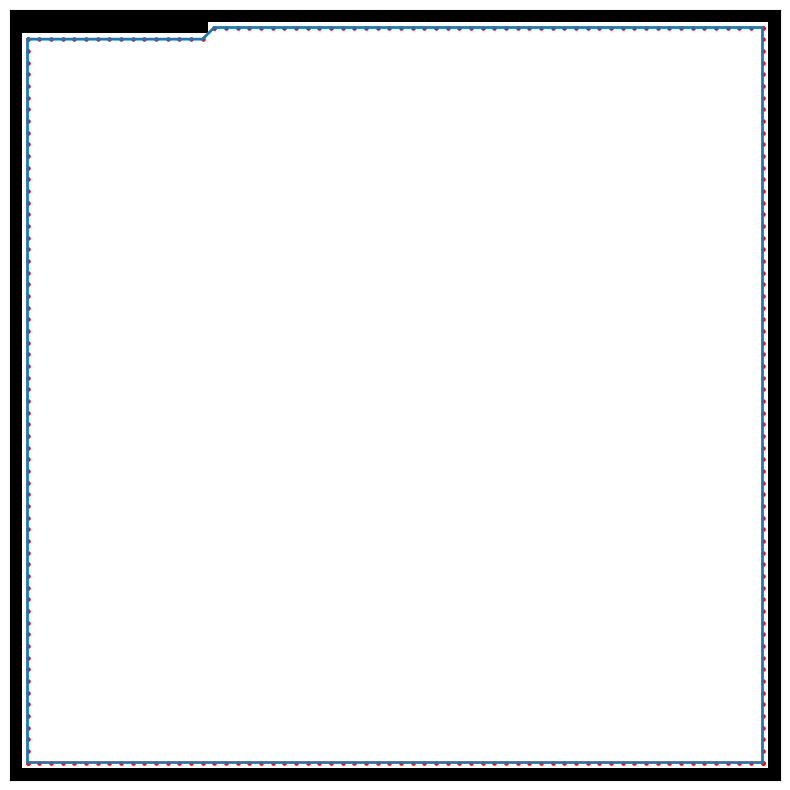

*** cur_mask:  (64, 64) -12.322285652160645 23.126577377319336
*** cur_mask_prob:  (64, 64) 4.451408016730707e-06 0.9999999999095819
64 64
*** contours:  (257, 2) [0.99900002 0.999     ] [64.00099998 64.001     ]


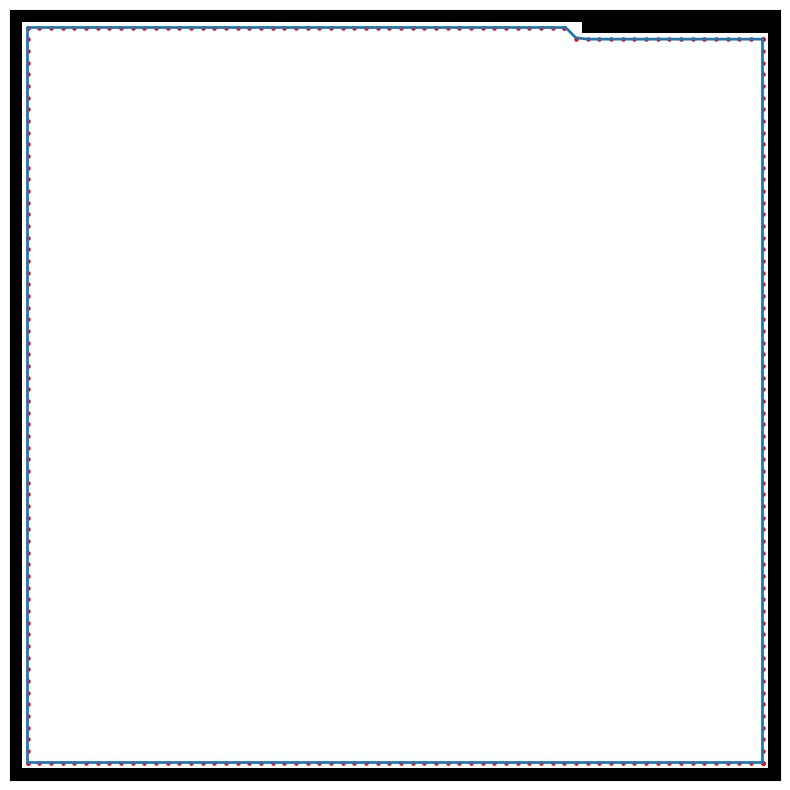

*** cur_mask:  (64, 64) -19.36343765258789 23.5296688079834
*** cur_mask_prob:  (64, 64) 3.895523917174349e-09 0.9999999999395781
64 64
*** contours:  (325, 2) [0.99900004 0.99900001] [64.00099985 64.00099999]


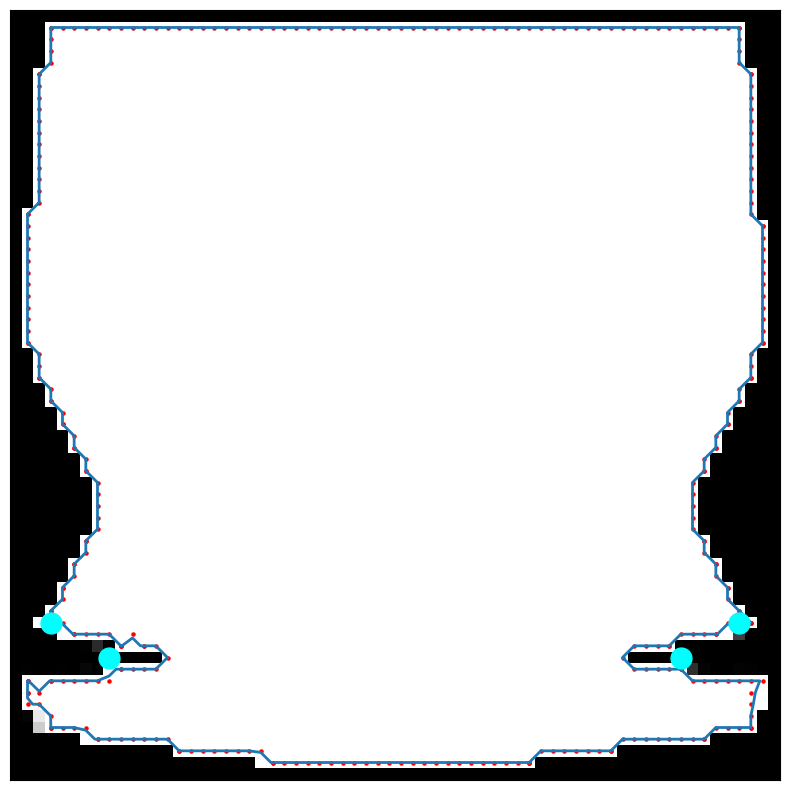

*** cur_mask:  (64, 64) -19.407419204711914 23.059926986694336
*** cur_mask_prob:  (64, 64) 3.727905800905275e-09 0.9999999999033502
64 64
*** contours:  (279, 2) [0.99900002 0.999     ] [64.00099995 64.001     ]


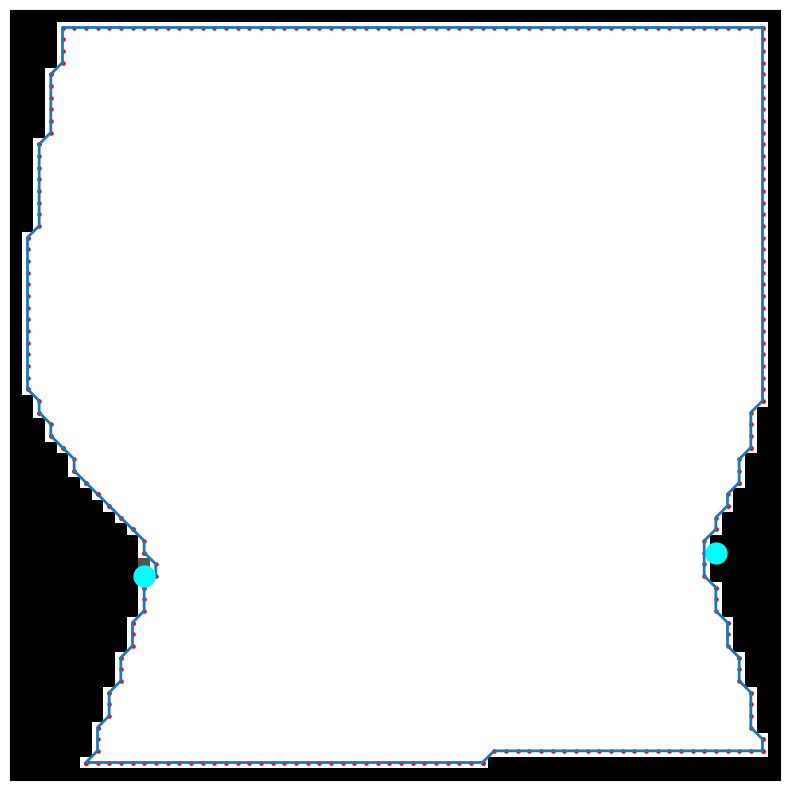

*** cur_mask:  (64, 64) -18.698867797851562 22.899633407592773
*** cur_mask_prob:  (64, 64) 7.571551737059464e-09 0.9999999998865472
64 64
*** contours:  (279, 2) [0.99900002 0.999     ] [64.00099993 64.00099999]


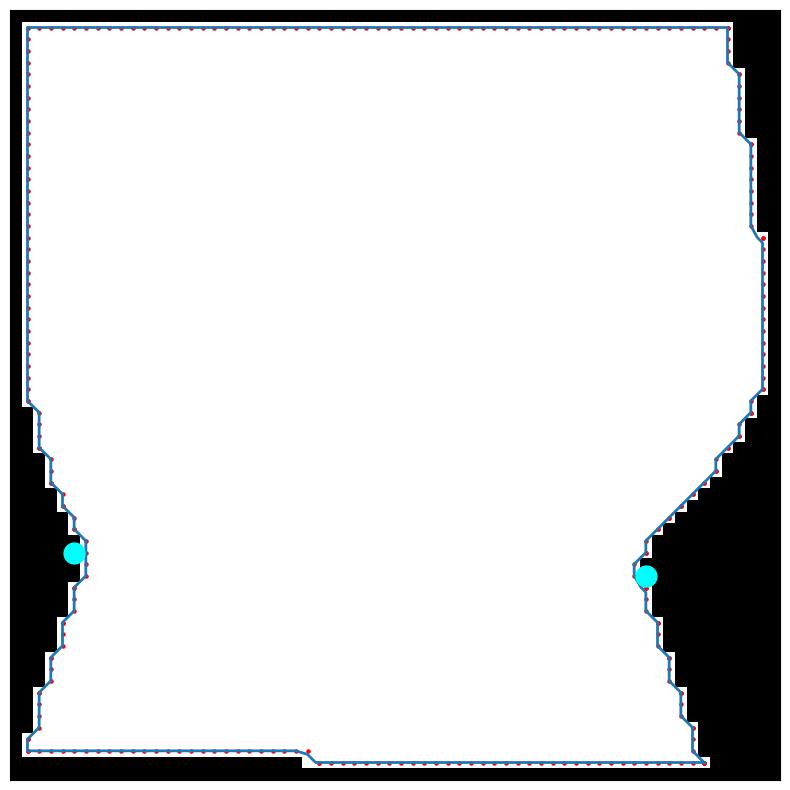

In [3]:
import os
import random
import pickle
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull

import torch
import torch.nn.functional as F

from shapely.geometry import MultiPoint, Polygon
from shapely.ops import unary_union, polygonize
from scipy.spatial import Delaunay

import open3d as o3d

from skimage import measure
from skimage.feature import corner_harris, corner_subpix, corner_peaks

from glob import glob

_PAD_SIZE = 1


def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)

    return pcd


def calculate_curvature(points, shift=1.0):
    vec1 = points - np.roll(points, shift, axis=0)
    vec2 = np.roll(points, -shift, axis=0) - points
    
    vec1 = vec1 / (np.linalg.norm(vec1, axis=1)[:, None] + 1e-6)
    vec2 = vec2 / (np.linalg.norm(vec2, axis=1)[:, None] + 1e-6)
    
    angles = np.arccos(np.sum(vec1 * vec2, axis=-1))      
    angles = angles / np.pi * 180
    
    return angles


def snap_coordinate(points, conf_mat):
    coord_x = points[:, 0]
    coord_y = points[:, 1]

    right = np.ceil(coord_x).astype(int)
    left = np.floor(coord_x).astype(int)
    top = np.ceil(coord_y).astype(int)
    bottom = np.floor(coord_y).astype(int)

    corner_conf_mat = np.stack([
        conf_mat[bottom, left], 
        conf_mat[bottom, right], 
        conf_mat[top, left], 
        conf_mat[top, right]], 
        axis=-1)

# data_root = "/data/lry/data/AIGP/demo_v2/Q2/brep_uni_norm"
# data_path = random.choice(glob(os.path.join(data_root, '*.pkl')))
# data_path = os.path.join(data_root, '1975.pkl')

data_path = 'test.pkl'

with open(data_path, "rb") as tf: data = pickle.load(tf)

print(data.keys())

data['surf_mask'] = data['new_surf_mask']
data['surf_uv_wcs'] = data['new_surf_uv_wcs']

uv_offset = data['uv_offset'][None]
uv_scale = data['uv_scale']

edge_3d_pts = []
corner_3d_pts = []

# fig, ax = plt.subplots(figsize=(20, 20))

for panel_idx in range(data['surf_uv_wcs'].shape[0]):
        
    cur_mask = data['surf_mask'][panel_idx, :, :, 0].astype(float)
    print('*** cur_mask: ', cur_mask.shape, cur_mask.min(), cur_mask.max())

    cur_mask = F.sigmoid(torch.tensor(cur_mask)).numpy()
    print('*** cur_mask_prob: ', cur_mask.shape, cur_mask.min(), cur_mask.max())
    
    panel_color = np.random.rand(3)
    
    H, W = data['surf_mask'].shape[1:3]
    print(H, W)

    # Find contours at a constant value of 0.5
    padded_mask = np.zeros((cur_mask.shape[0] + 2 * _PAD_SIZE, cur_mask.shape[1] + 2 * _PAD_SIZE))
    padded_mask[_PAD_SIZE:-_PAD_SIZE, _PAD_SIZE:-_PAD_SIZE] = cur_mask
    
    contours = measure.find_contours(padded_mask, 0.999)[0]
    corner_coords = corner_peaks(corner_harris(padded_mask), min_distance=3, threshold_rel=0.01)

    corner_contour_dist = np.linalg.norm(corner_coords[:, None] - contours[None], axis=-1)
    corner_contour_idx = np.argmin(corner_contour_dist, axis=1)
    
    print('*** contours: ', contours.shape, contours.min(axis=0), contours.max(axis=0))
    boundary_index = np.round(contours-_PAD_SIZE).astype(int)
    corner_index = boundary_index[corner_contour_idx, :]
        
    boundary_index[:, 0] = np.clip(boundary_index[:, 0] + _PAD_SIZE, 0, H-1+2*_PAD_SIZE)
    boundary_index[:, 1] = np.clip(boundary_index[:, 1] + _PAD_SIZE, 0, W-1+2*_PAD_SIZE)
    corner_index[:, 0] = np.clip(corner_index[:, 0], 0, H-1+2*_PAD_SIZE)
    corner_index[:, 1] = np.clip(corner_index[:, 1], 0, W-1+2*_PAD_SIZE)

    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(padded_mask, cmap='gray')
    ax.plot(contours[:, 1], contours[:, 0], linewidth=2)
    ax.scatter(boundary_index[:, 1], boundary_index[:, 0], s=5.0, c='r')
        
    ax.plot(
        corner_coords[:, 1], corner_coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=15
    )
    
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
        
    # break
    
#     # Extract 2D coordinate of boundary points
#     cur_panel_uvs = data['surf_uv_wcs'][panel_idx]
#     boundary_uvs = cur_panel_uvs[boundary_index[:, 0], boundary_index[:, 1]]
#     boundary_uvs = boundary_uvs * (uv_scale * 0.5) + uv_offset
#     ax.plot(boundary_uvs[:, 0], boundary_uvs[:, 1], linewidth=2, c=panel_color)

#     corner_uvs = cur_panel_uvs[corner_index[:, 0], corner_index[:, 1]]
#     corner_uvs = corner_uvs * (uv_scale * 0.5) + uv_offset
#     ax.scatter(corner_uvs[:, 0], corner_uvs[:, 1], c='r', s=20)
            
#     cur_panel_pts = data['surf_wcs'][panel_idx]
#     boundary_pts = cur_panel_pts[boundary_index[:, 0].astype(int), boundary_index[:, 1].astype(int)]
#     boundary_pts = boundary_pts * (data['global_scale'] * 0.5) + data['global_offset']
#     boundary_pts = _to_o3d_pc(boundary_pts, color=panel_color)
#     edge_3d_pts.append(boundary_pts)
    
#     corner_pts = cur_panel_pts[corner_index[:, 0], corner_index[:, 1]]
#     corner_pts = corner_pts * (data['global_scale'] * 0.5) + data['global_offset']
#     if corner_pts.shape[0] > 0:
#         corner_pts = _to_o3d_pc(corner_pts, color=np.array([1., 0., 0.]))
#         corner_3d_pts.append(corner_pts)

# ax.axis('equal')
# ax.axis('off')
# plt.show()

# mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0., 0., 0.])
# o3d.visualization.draw_geometries([mesh_frame] + edge_3d_pts + corner_3d_pts)

# Validate Panel Data




In [ ]:

import os
import json
from glob import glob
from tqdm import tqdm
import numpy as np
import shutil

from matplotlib import pyplot as plt

_MAX_NUM_PANELS = 32
_MAX_NUM_EDGES = 40

data_roots = [
    "\\\\192.168.29.222\\Share\\工程数据Q1\\objs", 
    "\\\\192.168.29.222\\Share\\工程数据Q2_objs"
    ]
all_items = []

print(">>> Locating data items...")
for data_root in data_roots:
    cur_items = glob(os.path.join(data_root, '**', 'pattern.json'), recursive=True)
    all_items += cur_items
    print("%d items in %s."%(len(cur_items), data_root))

num_panels = []
num_edges = []
    
invalid_other = []
invalid_wrong_panel_name = []
invalid_too_many_edges = []
invalid_too_many_panels = []
    
_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']
    
print(">>> Validating data items...")
for data_fp in tqdm(all_items):
    try:        
        with open(data_fp, 'r', encoding='utf-8') as f: pattern_spec = json.load(f)
        n_panels = len(pattern_spec['panels'])
        if n_panels > _MAX_NUM_PANELS:
            invalid_too_many_panels.append((data_fp, n_panels))
            print('[TOO_MANY_PANELS] %s: %d'%(data_fp, n_panels))
        
        num_panels.append(n_panels)
        for panel in pattern_spec['panels']:
            if panel['label'].strip().split()[0].split('_')[0] not in _PANEL_CLS:
                invalid_wrong_panel_name.append((data_fp, panel['id'], panel['label']))
                print('\t [WRONG_PANEL_LABEL] %s: %s - %s'%(data_fp, panel['id'], panel['label']))
            n_edges = sum([len(x['edges']) for x in panel['seqEdges'] if x['type'] == 3])
            if n_edges > _MAX_NUM_EDGES:
                invalid_too_many_edges.append((data_fp, panel['id'], n_edges))
                print('\t [TOO_MANY_EDGES] %s: %s - %d'%(data_fp, panel['id'], n_edges))
            num_edges.append(n_edges)
        
    except Exception as e:
        invalid_other.append(data_fp)
        print('Error in %s: %s'%(data_fp, e))
        continue
            
plt.hist(np.asarray(num_panels), bins=range(0, 100, 1))
plt.show()

plt.hist(np.asarray(num_edges), bins=range(0, 50, 1))
plt.show()

# move invalid items to seperate folder
print(">>> Moving invalid items to seperate directory...")
invalid_items_total = invalid_other + [x[0] for x in invalid_wrong_panel_name] + [x[0] for x in invalid_too_many_edges] + [x[0] for x in invalid_too_many_panels]
invalid_items_total = set([os.path.dirname(x) for x in invalid_items_total])
for src_item in tqdm(invalid_items_total):
    dst_item = src_item.replace("objs", "invalid")
    os.makedirs(os.path.dirname(dst_item), exist_ok=True)
    try:
        shutil.move(src_item, dst_item)
    except Exception as e:
        print("\t Failed to move %s to %s"%(src_item, dst_item))


############## Logging to file ##############
log_fp = "error_log.txt"
print(">>> Logging invalid items to %s..."%(log_fp))
with open(log_fp, 'w') as f:
    f.write(">>> INVALID: \n")
    for item in invalid_other:
        f.write("\t %s\n"%os.path.dirname(item).replace('工程数据Q1\objs', '工程数据Q1\sprojs').replace('工程数据Q2_objs', '工程数据Q2'))
    f.write("\n")
    f.write(">>> WRONG_PANEL_LABEL: \n")
    for item in invalid_wrong_panel_name:
        f.write("\t %s\n"%os.path.dirname(item[0]).replace('工程数据Q1\objs', '工程数据Q1\sprojs').replace('工程数据Q2_objs', '工程数据Q2'))
    f.write(">>> TOO_MANY_EDGES: \n")
    for item in invalid_too_many_edges:
        f.write("\t %s \t (edge_id: %s, num_edges: %d)\n"%(
            os.path.dirname(item[0]).replace('工程数据Q1\objs', '工程数据Q1\sprojs').replace('工程数据Q2_objs', '工程数据Q2'),
            item[1], item[2]
            ))
    f.write(">>> TOO_MANY_PANELS: \n")
    for item in invalid_too_many_panels:
        f.write("\t %s \t (num_panels: %d)\n"%(os.path.dirname(item[0]).replace('工程数据Q1\objs', '工程数据Q1\sprojs').replace('工程数据Q2_objs', '工程数据Q2'), item[1]))

# Test SDF pattern (&& Countor Finding)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure


# Construct some test data
x, y = np.ogrid[-np.pi : np.pi : 100j, -np.pi : np.pi : 100j]
r = np.sin(np.exp(np.sin(x) ** 3 + np.cos(y) ** 2))

print(r.shape, r.max(), r.min())    # (-1.0, 1.0)

# Find contours at a constant value of 0.8
contours = measure.find_contours(r, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
import numpy as np

def calculate_curvature(points):
    vec1 = points - np.roll(points, 1, axis=0)
    vec2 = np.roll(points, -1, axis=0) - points
    
    vec1 = vec1 / np.linalg.norm(vec1, axis=1)[:, None]
    vec2 = vec2 / np.linalg.norm(vec2, axis=1)[:, None]
    
    angles = np.arccos(np.sum(vec1 * vec2, axis=-1))      
    angles = angles / np.pi * 180
    
    return angles

pts = np.array([[0, 0], [1, 1], [2, 1], [3, 0], [1.5, -1.5]])
angles = calculate_curvature(pts)
print(angles)
print(np.where(angles > 75))